In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
# import talib
import pickle
import pystan

import os, sys

sys.path.append(os.path.abspath(os.path.join('../src')))
from generative_models import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [41]:
# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [ ]:
# gpu setting and checking
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

## Stan

In [ ]:
stan_model = """
data {
  int<lower=0> N;                 
  real<lower=0> rt[N];    
  int<lower=0,upper=1> correct[N];
  int<lower=1,upper=4> context[N];
}

parameters {
  real<lower=0> v[4];
  real<lower=0> a; 
  real<lower=0> ndt;
}

model {
  // Priors
  v ~ gamma(2.5, 1.5);
  a ~ gamma(4.0, 3.0);
  ndt ~ gamma(1.5, 5.0);
  
  for (n in 1:N) {
     if (correct[n] == 1) {
        rt[n] ~ wiener(a, ndt, 0.5, v[context[n]]);
     } 
     else {
        rt[n] ~ wiener(a, ndt, 1 - 0.5, -v[context[n]]);
     }
  }
}
"""

In [ ]:
def to_stan(sim_data):
    """
    Convert data from simulator to stan-friendly format.
    """
    rt = sim_data[:, 0]
    context = sim_data[:, 1].astype(np.int32) + 1
    correct = (rt >= 0).astype(np.int32)
    rt = np.abs(rt).astype(np.float32)
    return {'rt': rt, 'correct': correct, 'context': context, 'N': rt.shape[0]}

def loop_stan(data, verbose=True):
    """
    Loop through data and obtain posteriors.
    """
    
    stan_post_samples = []
    for i in range(data.shape[0]):
        data_i = to_stan(data[i])
        ndt_init = data_i['rt'].min() * 0.75
        init = {'ndt': ndt_init}
        fit = sm.sampling(data=data_i, 
                          iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                          control=dict(adapt_delta=0.99, max_treedepth=15))
        samples = fit.extract(permuted=True)
        stan_post_samples.append(samples)
        if verbose:
            print(f'Finished estimating data set {i + 1}...')
    return stan_post_samples

# Simulation

In [2]:
N_OBS = 3200
BATCH_SIZE = 100

In [ ]:
# parallelization for stan
import multiprocessing
multiprocessing.set_start_method("fork")

In [ ]:
# compile stan model
sm = pystan.StanModel(model_code=stan_model)

## No variance (static)

In [3]:
prior_draws = dynamic_prior(BATCH_SIZE)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d = static_batch_simulator(prior_draws, context)
sim_data.shape

(100, 3200, 2)

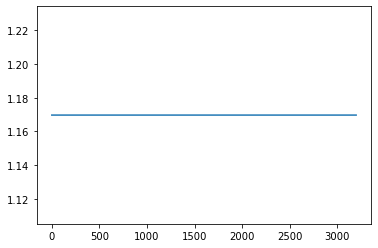

In [6]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [5]:
pickle.dump(
{
    'rt': sim_data[:, : , 0], 
    'context': sim_data[:, : , 1], 
    'theta_d': theta_d,
    }, 
    open('sim_data_ablation/sim_data_ablation_3200_noVar.pkl', 'wb+')
)

In [ ]:
# stan_post_samples = loop_stan(sim_data)

## Low variance

In [7]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.001)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

(100, 3200, 2)

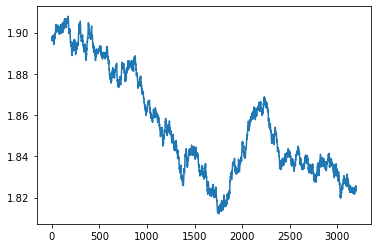

In [8]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [10]:
pickle.dump(
{
    'rt': sim_data[:, : , 0], 
    'context': sim_data[:, : , 1], 
    'theta_d': theta_d,
    }, 
    open('sim_data_ablation/sim_data_ablation_3200_lowVar.pkl', 'wb+')
)

In [ ]:
# stan_post_samples = loop_stan(sim_data)

## High variance

In [11]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.1)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

(100, 3200, 2)

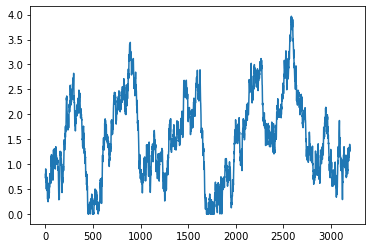

In [12]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [13]:
pickle.dump(
{
    'rt': sim_data[:, : , 0], 
    'context': sim_data[:, : , 1], 
    'theta_d': theta_d,
    }, 
    open('sim_data_ablation/sim_data_ablation_3200_highVar.pkl', 'wb+')
)

In [ ]:
# stan_post_samples = loop_stan(sim_data)

# Amortizers

## Network architecture

In [26]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

class StaticHeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(StaticHeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        
    def call(self, x):
        """
        Forward pass through the model.
        """
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        return preds_dyn

## Loss

In [22]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [24]:
def epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar, fixed_var):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            # Simulate from model
            prior_draws = dynamic_prior(batch_size, fixed_var)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)

            # predict
            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d, pred_theta_s = network(net_in)

            # loss
            loss_d = nll(theta_d, pred_theta_d)
            loss_s = nll(theta_s, pred_theta_s)
            total_loss = loss_d + loss_s

        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

def static_epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d = static_batch_simulator(prior_draws, context)

            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d = network(net_in)

            # Loss 
            loss_d = nll(theta_d, pred_theta_d)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)
            
        total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

## Training

In [ ]:
N_OBS = 3200
BATCH_SIZE = 8
STEPS_PER_EPOCH = 1000
epochs = [50, 25, 25]
learning_rates = [0.0001, 0.00005, 0.00001]

### No variance (static)

In [ ]:
network = StaticHeteroscedasticNetwork(6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            static_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)
    
    #save weights
    network.save_weights('checkpoints/ablation_static_3200')

### Low variance

In [ ]:
network = HeteroscedasticNetwork(6, 6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.001)
    
    #save weights
    network.save_weights('checkpoints/ablation_lowVar_3200')

### High variance

In [ ]:
network = HeteroscedasticNetwork(6, 6)

In [ ]:
%%time
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.1)
    
    #save weights
    network.save_weights('checkpoints/ablation_highVar_3200')

# Evaluation

In [28]:
# load trained network
network_no_var   = StaticHeteroscedasticNetwork(6)
network_low_var  = HeteroscedasticNetwork(6, 6)
network_high_var = HeteroscedasticNetwork(6, 6)
network_no_var.load_weights('checkpoints_ablation/ablation_static_3200')
network_low_var.load_weights('checkpoints_ablation/ablation_lowVar_3200')
network_high_var.load_weights('checkpoints_ablation/ablation_highVar_3200')

In [66]:
def plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, res, types):
    # get mean and sd of posterior sd's from Bayesflow fits
    bf_post_no_var_sd   = np.array(bf_post_no_var.stddev()).mean(axis=0)
    bf_post_low_var_sd  = np.array(bf_post_low_var.stddev()).mean(axis=0)
    bf_post_high_var_sd = np.array(bf_post_high_var.stddev()).mean(axis=0)
    bf_post_no_var_sd_sd   = np.array(bf_post_no_var.stddev()).std(axis=0)
    bf_post_low_var_sd_sd  = np.array(bf_post_low_var.stddev()).std(axis=0)
    bf_post_high_var_sd_sd = np.array(bf_post_high_var.stddev()).std(axis=0)

    # get mean and sd posterior sd's from Stan fits
    stan_sd = np.zeros((100, 6))
    for j in range(100):
        v = stan_post_samples[j]['v']
        a = stan_post_samples[j]['a']
        ndt = stan_post_samples[j]['ndt']

        stan_posterior = np.c_[v, a, ndt]
        stan_sd[j] = stan_posterior.std(axis=0)

    stan_sd_sd = stan_sd.std(axis=0)
    stan_sd = stan_sd.mean(axis=0)

    # plotting info
    labels = ['No variance', 'Low variance', 'High variance', "Static Stan"]
    param_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    colors = ['#e3a3a3', '#a63636', '#511515', "#000000"]
    # colors = ['#d36666', '#852626', '#5d1b1b', "#000000"]
    param_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
    alpha_line = 0.8
    alpha_fill = 0.3
    linewidth = 3

    # plotting time window
    x_min = int(bf_post_no_var_sd.shape[0] - res)
    time = np.arange(x_min, bf_post_no_var_sd.shape[0])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

    # iterate over parameters
    for i, ax in enumerate(axarr.flat):
        # plot Bayesflow results
        ax.plot(time, bf_post_no_var_sd[x_min:, i], color=colors[0], label=labels[0], alpha=alpha_line, linewidth=linewidth)
        ax.plot(time, bf_post_low_var_sd[x_min:, i], color=colors[1], label=labels[1], alpha=alpha_line, linewidth=linewidth)
        ax.plot(time, bf_post_high_var_sd[x_min:, i], color=colors[2], label=labels[2], alpha=alpha_line, linewidth=linewidth)
        ax.fill_between(time, bf_post_no_var_sd[x_min:, i]+bf_post_no_var_sd_sd[x_min:, i]/2, bf_post_no_var_sd[x_min:, i]-bf_post_no_var_sd_sd[x_min:, i]/2, color=colors[0], alpha=alpha_fill)
        ax.fill_between(time, bf_post_low_var_sd[x_min:, i]+bf_post_low_var_sd_sd[x_min:, i]/2, bf_post_low_var_sd[x_min:, i]-bf_post_low_var_sd_sd[x_min:, i]/2, color=colors[1], alpha=alpha_fill)
        ax.fill_between(time, bf_post_high_var_sd[x_min:, i]+bf_post_high_var_sd_sd[x_min:, i]/2, bf_post_high_var_sd[x_min:, i]-bf_post_high_var_sd_sd[x_min:, i]/2, color=colors[2], alpha=alpha_fill)

        # plot Stan results
        ax.hlines(y=stan_sd[i], xmin=x_min, xmax=800, color=colors[3], label=labels[3], linestyles="dashed", linewidth=1.5)
        stan_sd_array = np.repeat(stan_sd[i], len(time))
        ax.fill_between(time, stan_sd_array+stan_sd_sd[i]/2, stan_sd_array-stan_sd_sd[i]/2, color=colors[3], alpha=0.2)

        # set appropriate x-axis limits
        max_val = np.array([bf_post_no_var_sd[x_min:, i], 
                            bf_post_low_var_sd[x_min:, i],
                            bf_post_high_var_sd[x_min:, i]]).max()
        ax.set_ylim(0, max_val + max_val/2)

        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Posterior standard deviation', fontsize=18)
        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=20)
        ax.set_xticks(np.arange(0, 3201, 800))
        ax.tick_params(axis='both', which='major', labelsize=16)

        if i == 0:  
            f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)
            f.suptitle("Parameter SDs over time: {}".format(labels[types]) + " simulated data\n", fontsize=22)

    f.tight_layout()

In [68]:
def plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, types):
    # get mean and sd of posterior means's from Bayesflow fits
    bf_post_mean_no_var      = np.array(bf_post_no_var.mean()).mean(axis=0)
    bf_post_mean_low_var     = np.array(bf_post_low_var.mean()).mean(axis=0)
    bf_post_mean_high_var    = np.array(bf_post_high_var.mean()).mean(axis=0)
    bf_post_mean_no_var_sd   = np.array(bf_post_no_var.mean()).std(axis=0)
    bf_post_mean_low_var_sd  = np.array(bf_post_low_var.mean()).std(axis=0)
    bf_post_mean_high_var_sd = np.array(bf_post_high_var.mean()).std(axis=0)

    # get mean and sd posterior mean's from Stan fits
    stan_mean = np.zeros((100, 6))
    for j in range(100):
        v = stan_post_samples[j]['v']
        a = stan_post_samples[j]['a']
        ndt = stan_post_samples[j]['ndt']

        stan_posterior = np.c_[v, a, ndt]
        stan_mean[j] = stan_posterior.mean(axis=0)

    stan_mean_sd = stan_mean.std(axis=0)
    stan_mean = stan_mean.mean(axis=0)

    sqrt_err_no_var = (bf_post_mean_no_var - stan_mean)**2
    sqrt_err_low_var = (bf_post_mean_low_var - stan_mean)**2
    sqrt_err_high_var = (bf_post_mean_high_var - stan_mean)**2

    # plotting info
    labels = ['No variance', 'Low variance', 'High variance']
    param_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    
    colors = ['#e3a3a3', '#a63636', '#511515', "#000000"]
    # colors = ['#d36666', '#852626', '#5d1b1b', "#000000"]
    param_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
    alpha_line = 0.8
    linewidth = 3

    # plotting time window
    time = np.arange(sqrt_err_no_var.shape[0])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

    # iterate over parameters
    for i, ax in enumerate(axarr.flat):
        # plot Bayesflow results
        ax.plot(time, sqrt_err_no_var[:, i], color=colors[0], label=labels[0], alpha=alpha_line, linewidth=linewidth)
        ax.plot(time, sqrt_err_low_var[:, i], color=colors[1], label=labels[1], alpha=alpha_line, linewidth=linewidth)
        ax.plot(time, sqrt_err_high_var[:, i], color=colors[2], label=labels[2], alpha=alpha_line, linewidth=linewidth)

        # set appropriate x-axis limits
        max_val = np.array([sqrt_err_no_var[:, i], 
                            sqrt_err_low_var[:, i],
                            sqrt_err_high_var[:, i]]).max()
        ax.set_ylim(0, max_val + max_val/2)

        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Squared Error of posterior mean', fontsize=18)
        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=20)
        ax.set_xticks(np.arange(0, 3201, 800))
        ax.tick_params(axis='both', which='major', labelsize=16)

        if i == 0:  
            f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)
            f.suptitle("Difference between posterior means of BayesFlow and Stan: 100 {}".format(labels[types]) + " simulated data\n", fontsize=22)

    f.tight_layout()

### No variance (static)

In [29]:
# load simulated data and stan fits
sim = pd.read_pickle('sim_data_ablation/sim_800_noVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
stan_post_samples = sim['stan_post_samples']

In [30]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

2022-04-19 15:15:31.119657: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_4667/3580442311.py:71: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


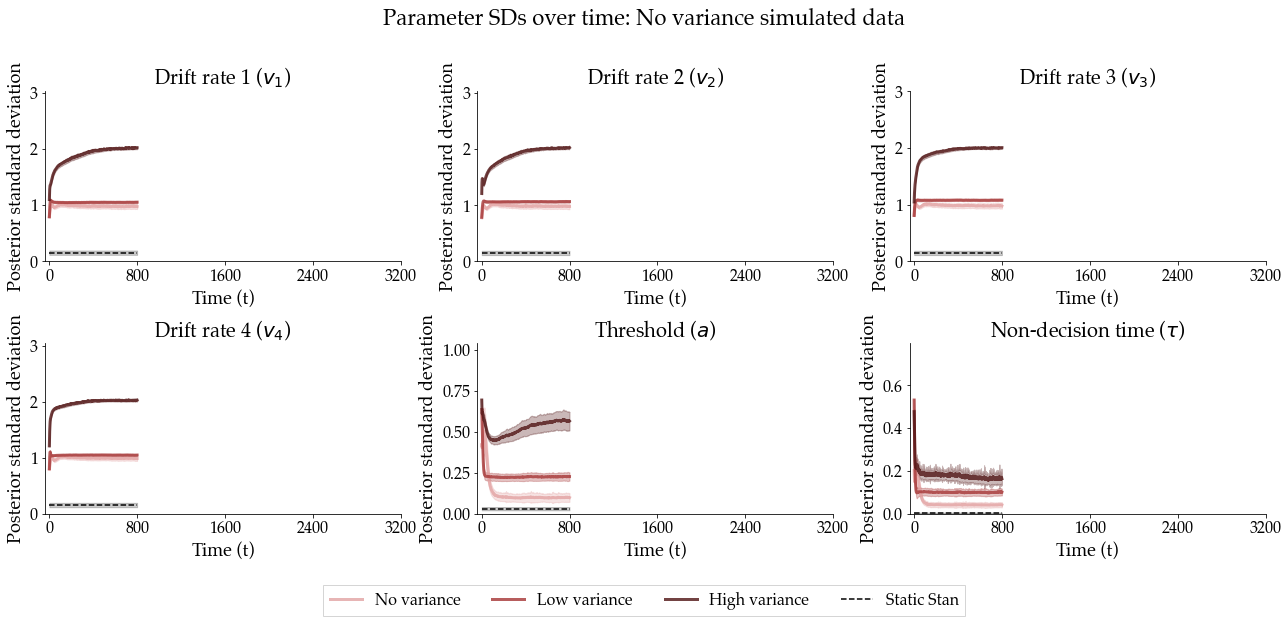

In [67]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var[0], bf_post_high_var[0], 800, 0)

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_4667/340359763.py:66: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


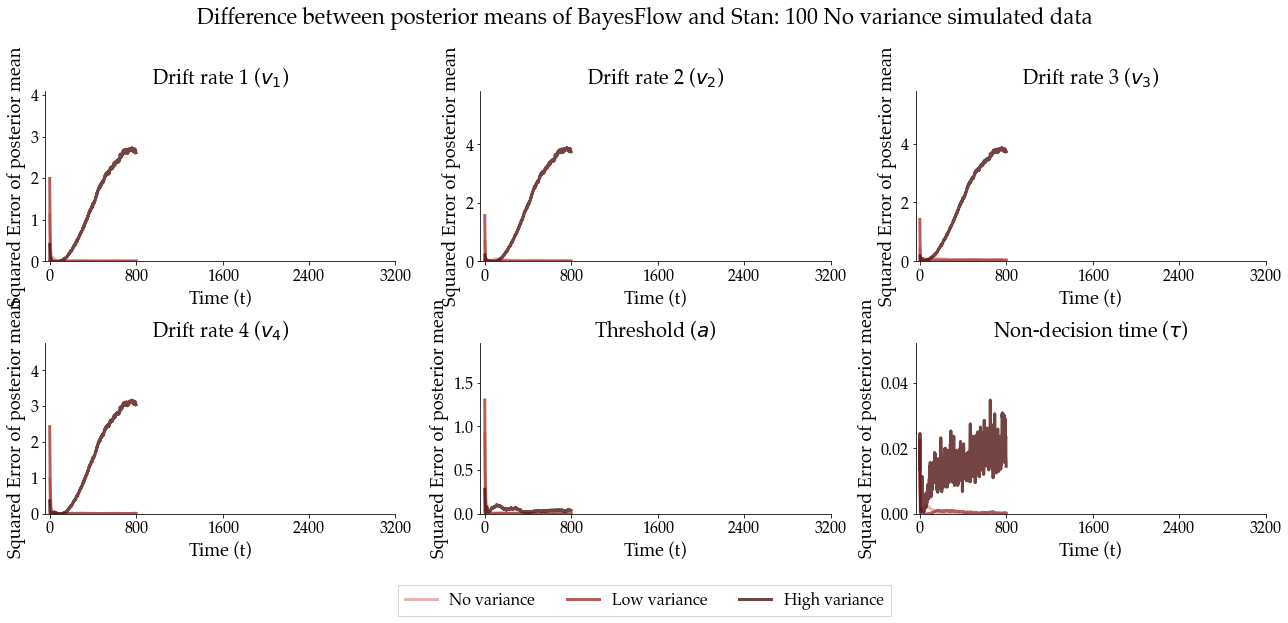

In [69]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var[0], bf_post_high_var[0], 0)

### Low variance

In [ ]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_lowVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

In [ ]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

In [35]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 800, 1)

AttributeError: 'tuple' object has no attribute 'stddev'

In [ ]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 1)

### High variance

In [ ]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_highVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

In [ ]:
# amortized inference
bf_post_no_var   = network_no_var(sim_data)
bf_post_low_var  = network_low_var(sim_data)
bf_post_high_var = network_high_var(sim_data)

In [ ]:
plot_post_sd(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 800, 2)

In [ ]:
plot_post_mean_error(stan_post_samples, bf_post_no_var, bf_post_low_var, bf_post_high_var, 2)